### Testing temporal network metrics

Testing the temporal network functions for network metrics using the "Primary school temporal network data. This data set contains the temporal network of contacts between the children and teachers used in the study published in BMC Infectious Diseases 2014. The file contains a tab-separated list representing the active contacts during $20$-second intervals of the data collection. Each line has the form $t_{ij}$, $C_i$, $C_j$, where $i$ and $j$ are the anonymous IDs of the persons in contact, $C_i$ and $C_j$ are their classes, and the interval during which this contact was active is $[t-20s, t]$. If multiple contacts are active in a given interval, you will see multiple lines starting with the same value of $t$. Time is measured in seconds.

In [6]:
# Adding GDa to path
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import brainconn as bc
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns

from tqdm import tqdm 
from GDa.net.layerwise import (compute_nodes_degree, compute_network_partition,
                               compute_nodes_clustering, compute_nodes_coreness, 
                               compute_nodes_distances,
                               compute_nodes_efficiency)

#### Loading dataset

In [2]:
_DATA_PATH      = 'data-sets/primaryschool/primaryschool.csv'
_META_DATA_PATH = 'data-sets/primaryschool/metadata_primaryschool.txt'

In [3]:
def _load_data_as_adj(data_path, meta_data_path, verbose=False):
    # Loading data and metadata
    data     = pd.read_csv(data_path, header=None, delimiter='\t', usecols=[0,1,2], names=['t','i','j','Ci','Cj'])
    metadata = np.loadtxt(meta_data_path, usecols=(0,1), dtype=str)
    # Mapping nodes labels to indexes
    idx      = np.arange(metadata.shape[0], dtype=int)
    # Numerical labels to index
    n_labels = dict( zip(metadata[:,0].astype(int),idx) )
    # Literal labels to index
    s_labels = metadata[:,1]
    # Replacing nodes labes
    data['i'] = data['i'].map(n_labels)
    data['j'] = data['j'].map(n_labels)
    # Get sources and targets
    x_s   = data.groupby('t')['i'].apply(list)
    x_t   = data.groupby('t')['j'].apply(list)
    #times = x_s.index.values 
    # Convert to array
    x_s   = x_s.values
    x_t   = x_t.values
    # Get number of nodes and time-points
    n_nodes  = len(metadata[:,0])
    n_times  = len(x_s)
    times    = np.arange(n_times, dtype=int)
    # Adjacency tensor
    A   = np.zeros((n_nodes,n_nodes,n_times))
    itr = range(len(times))
    for t in tqdm(itr) if verbose else itr:
        A[x_s[t],x_t[t],t] = A[x_t[t],x_s[t],t] = 1
        np.fill_diagonal(A[...,t], 0)
    # Convert to x-array
    A = xr.DataArray( A[:,:,None,:], dims=("sources", "targets", "trials", "times"),
                         coords={"sources":s_labels, 
                                 "targets":s_labels, 
                                 "times":times}
                    )
    return A

In [4]:
A = _load_data_as_adj(_DATA_PATH, _META_DATA_PATH, verbose=True)

100%|██████████| 3100/3100 [00:00<00:00, 26542.98it/s]


#### Layerwise strength and modularity

In [5]:
strength = compute_nodes_degree(A)
p_ig, m_ig = compute_network_partition(A,  kw_bc={}, backend='igraph', n_jobs=1, verbose=False)
p_bc, m_bc = compute_network_partition(A,  kw_bc={}, backend='brainconn', n_jobs=20, verbose=False)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

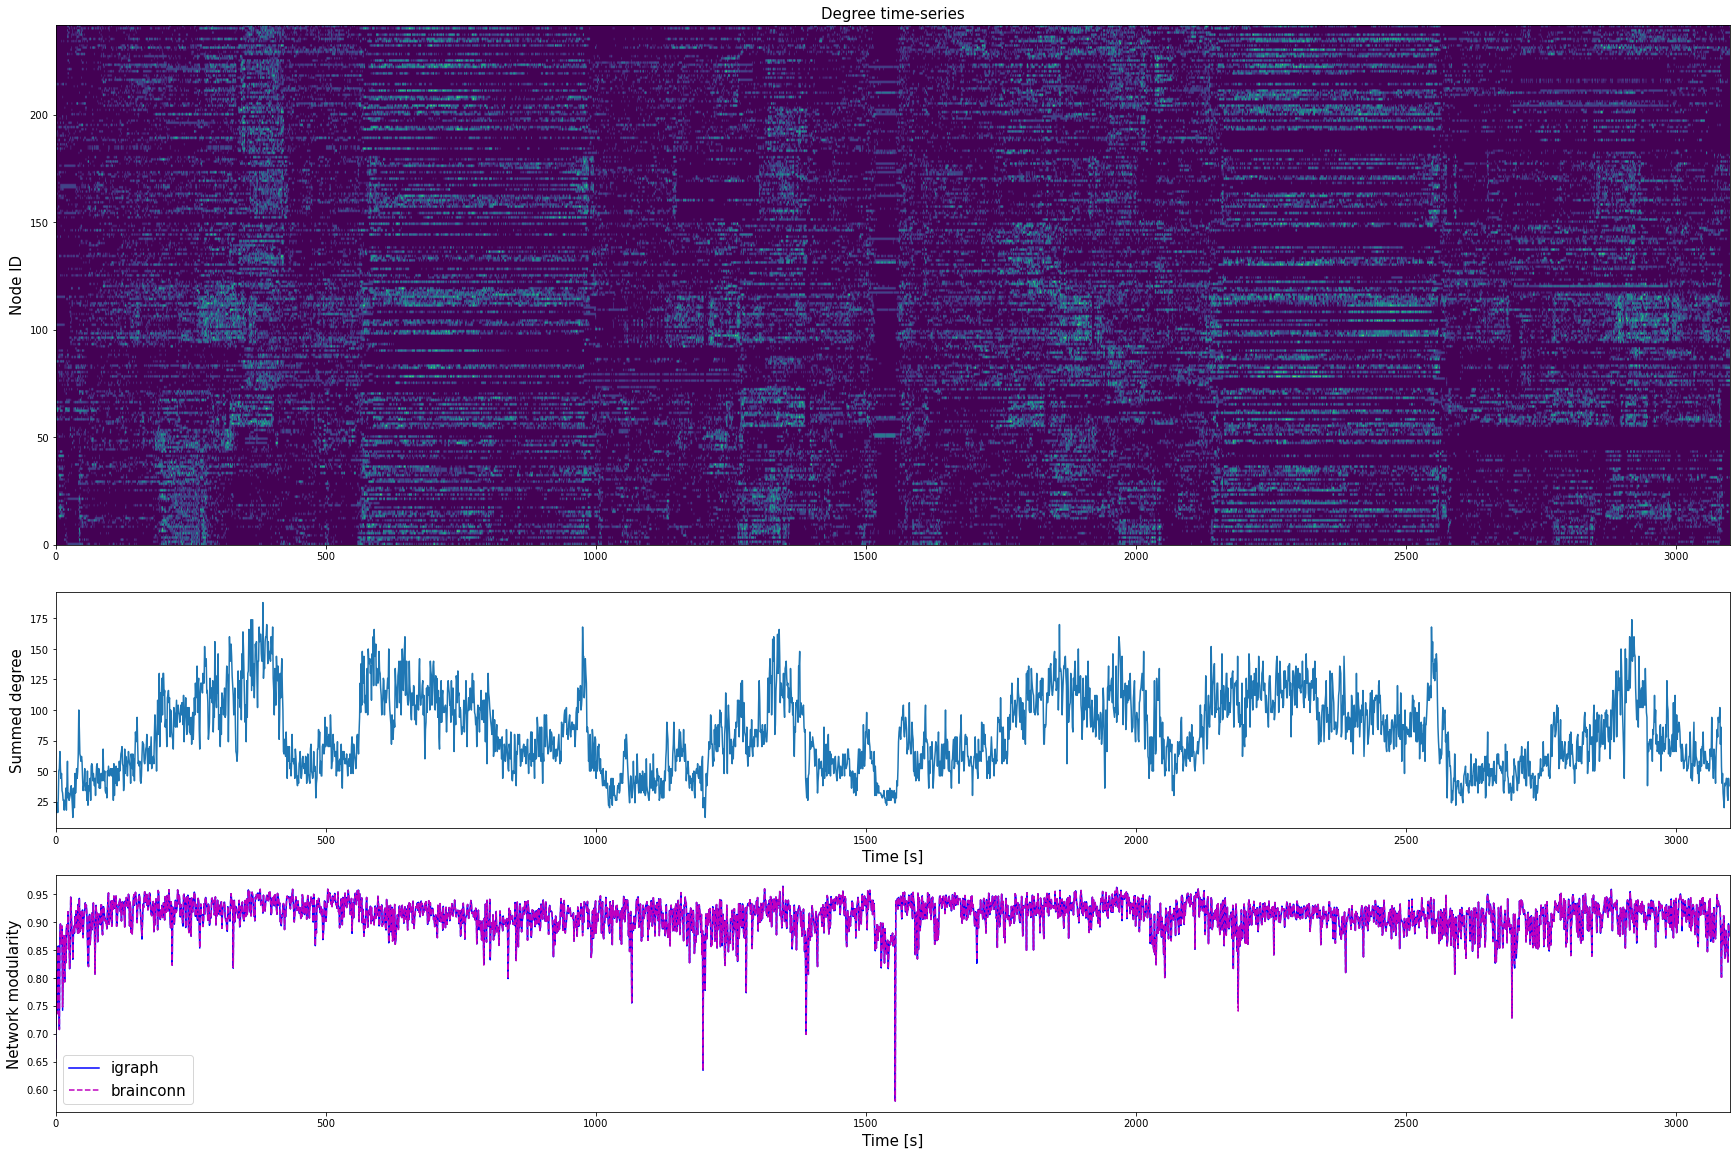

In [6]:
plt.figure(figsize=(30,20))
plt.subplot2grid((4,3),(0,0),rowspan=2,colspan=3)
plt.imshow(strength.isel(trials=0), aspect='auto', cmap='viridis', 
           origin='lower', extent=[0, A.sizes['times'], 0, A.sizes['sources']],
           vmin=0, vmax=5)
plt.ylabel('Node ID', fontsize=15)
#plt.yticks(range(A.sizes['sources']),A.sources.values)
plt.title('Degree time-series', fontsize=15)
plt.subplot2grid((4,3),(2,0),rowspan=1,colspan=3)
plt.plot(strength.isel(trials=0).sum(dim='roi').values )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Summed degree', fontsize=15)
plt.subplot2grid((4,3),(3,0),rowspan=1,colspan=3)
plt.plot( m_ig.isel(trials=0), 'b'  , label='igraph')
plt.plot( m_bc.isel(trials=0), 'm--', label='brainconn' )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Network modularity', fontsize=15)
plt.legend(fontsize=15);

#### Coreness

In [7]:
coreness_ig = compute_nodes_coreness(A, kw_bc={}, verbose=False, backend='igraph',
                       n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [8]:
coreness_bc = compute_nodes_coreness(A, kw_bc={}, verbose=False, backend='brainconn',
                                     n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

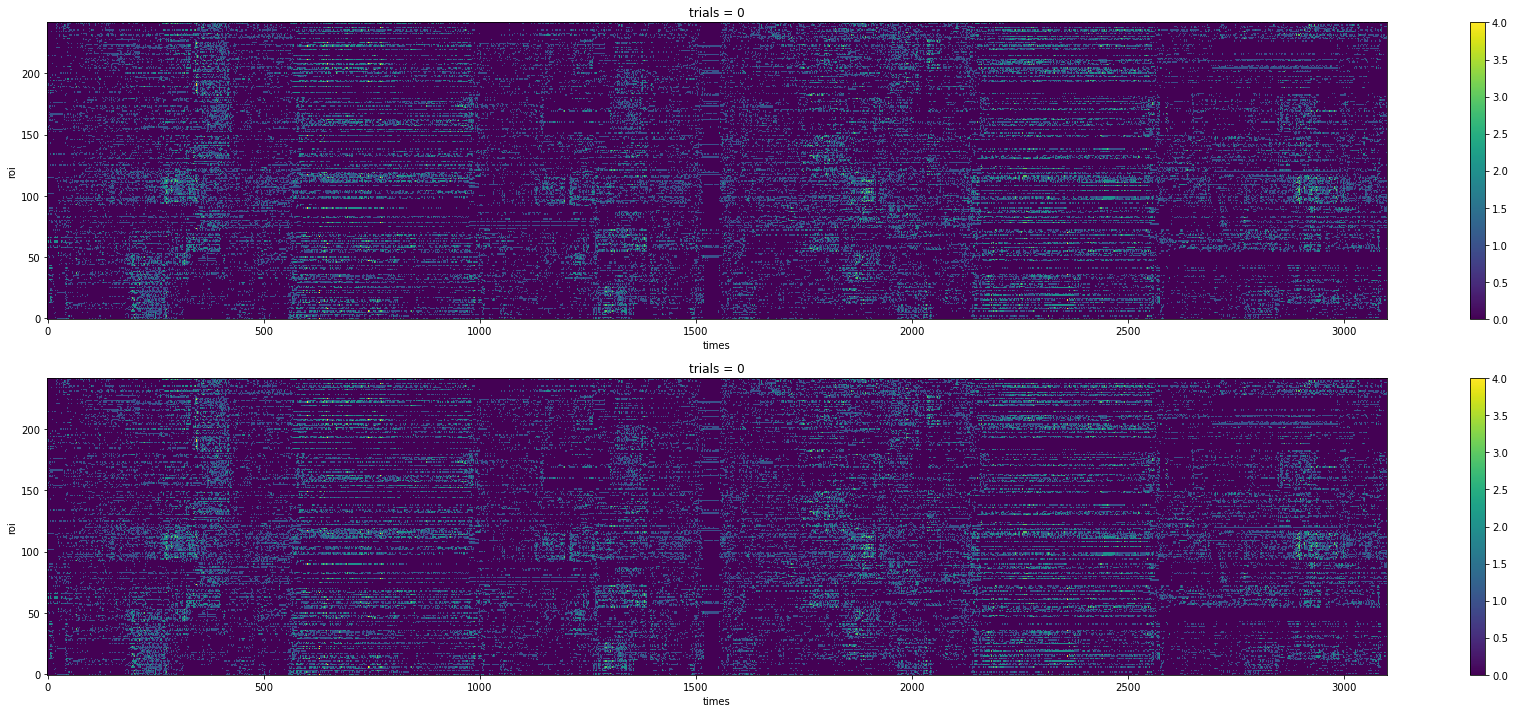

In [9]:
plt.figure(figsize=(30,12))
plt.subplot(2,1,1)
coreness_ig.isel(trials=0).plot.imshow(x="times", y="roi")
plt.subplot(2,1,2)
coreness_bc.isel(trials=0).plot.imshow(x="times", y="roi")

#### Clustering

In [10]:
clustering_ig = compute_nodes_clustering(A, verbose=False, backend='igraph',
                                         n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [11]:
clustering_bc = compute_nodes_clustering(A, verbose=False, backend='brainconn',
                                         n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

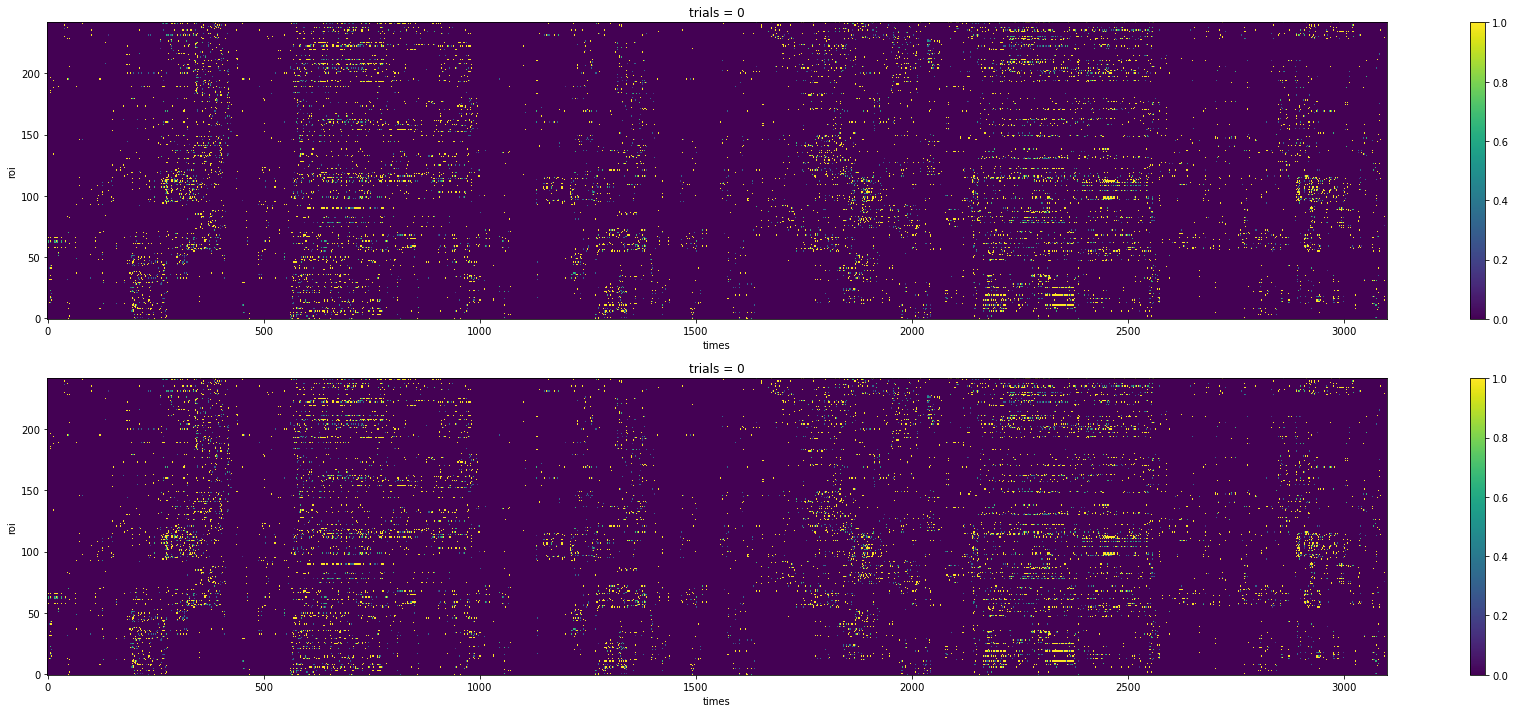

In [12]:
plt.figure(figsize=(30,12))
plt.subplot(2,1,1)
clustering_ig.isel(trials=0).plot.imshow(x="times", y="roi")
plt.subplot(2,1,2)
clustering_bc.isel(trials=0).plot.imshow(x="times", y="roi")

#### Shortest-path

In [9]:
dig = compute_nodes_distances(A, backend="igraph", verbose=False, n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [8]:
dbc = compute_nodes_distances(A, backend="brainconn", verbose=False, n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [13]:
np.nansum(dig-dbc)

0.0